In [ ]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from PIL import Image
from google.colab import drive
import copy
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import random
import torchvision

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_directory = pathlib.Path('/content/drive/MyDrive/DatasetF')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_names = [item.name for item in (data_directory / 'train').glob('*')]
print("Class names:", class_names)


Class names: ['ship', 'cars', 'airplanes']


In [ ]:
data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_data = ImageFolder(root=os.path.join(data_directory, 'train'), transform=data_transforms)
test_data = ImageFolder(root=os.path.join(data_directory, 'test'), transform=data_transforms)

In [ ]:
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

In [ ]:
# Data loaders with optimized loading
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

Sorted class names: ['airplanes', 'cars', 'ship']
Batch labels: tensor([2, 0, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 0, 0, 0, 2, 2, 0, 0,
        1, 2, 0, 1, 2, 1, 2, 0])


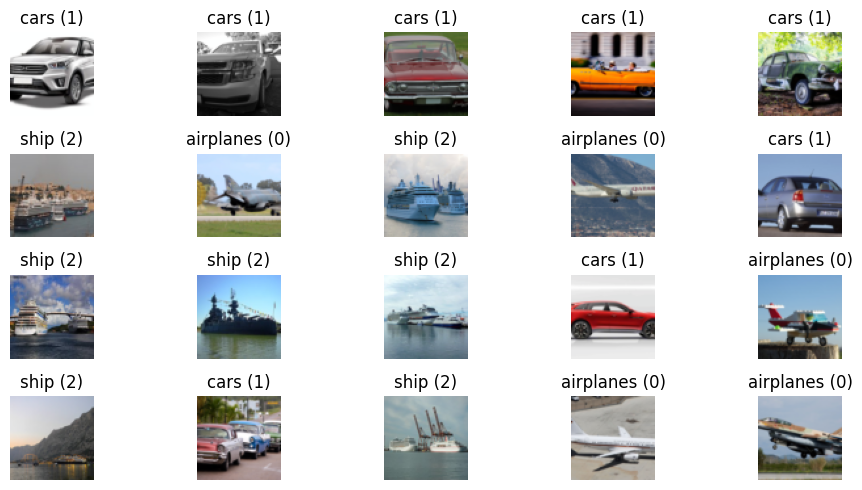

In [ ]:
class_names = sorted([item.name for item in (data_directory / 'train').glob('*')])
print("Sorted class names:", class_names)

for inputs, labels in train_loader:
    print("Batch labels:", labels)
    break

def plot_images(images, labels):
    plt.figure(figsize=(10, 5))
    for i, (image, label) in enumerate(zip(images, labels), 1):
        if i > 20: break
        plt.subplot(4, 5, i)
        image = image.numpy().transpose((1, 2, 0)) * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        plt.imshow(image.clip(0, 1))
        plt.title(f"{class_names[label]} ({label})")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Re-run the visualization
data_iter = iter(train_loader)
images, labels = next(data_iter)
plot_images(images, labels)


In [88]:
class ImageClassifier(nn.Module):
    def __init__(self, model_name):
        super(ImageClassifier, self).__init__()
        dropout_rate = 0.6

        if model_name == "DenseNet121":
            self.model = models.densenet121(pretrained=True)
            num_ftrs = self.model.classifier.in_features
            self.model.classifier = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(num_ftrs, 3)
            )
        elif model_name == "VGG16":
            self.model = models.vgg16(pretrained=True)
            num_ftrs = self.model.classifier[6].in_features
            self.model.classifier[6] = nn.Sequential(
                self.dropout,
                nn.Linear(num_ftrs, 3)
            )
        elif model_name == "ResNet18":
            self.model = models.resnet18(pretrained=True)
            num_ftrs = self.model.fc.in_features
            self.model.fc = nn.Linear(num_ftrs, 3)

    def forward(self, x):
        return self.model(x)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=7):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        history['train_acc'].append(epoch_acc.item())

        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        history['val_acc'].append(val_acc.item())

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model, history

def evaluate_model(model, test_loader):
    model.eval()
    corrects = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

    accuracy = corrects.double() / total
    print(f'Test Accuracy: {accuracy:.4f}')

# Initialize and use the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImageClassifier('ResNet18').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)

# Assuming train_loader, val_loader, and test_loader are defined elsewhere
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs= 7)
evaluate_model(model, test_loader)


Epoch 1/7, Train Loss: 1.1734, Train Acc: 0.5611, Val Loss: 19.8627, Val Acc: 0.4498
Epoch 2/7, Train Loss: 0.8724, Train Acc: 0.6479, Val Loss: 1.6375, Val Acc: 0.6651
Epoch 3/7, Train Loss: 0.7712, Train Acc: 0.7132, Val Loss: 0.7688, Val Acc: 0.7177
Epoch 4/7, Train Loss: 0.5818, Train Acc: 0.7928, Val Loss: 0.5745, Val Acc: 0.7895
Epoch 5/7, Train Loss: 0.7644, Train Acc: 0.7335, Val Loss: 8.3955, Val Acc: 0.5574
Epoch 6/7, Train Loss: 0.7260, Train Acc: 0.7401, Val Loss: 0.5787, Val Acc: 0.7727
Epoch 7/7, Train Loss: 0.6393, Train Acc: 0.7778, Val Loss: 0.5586, Val Acc: 0.7990
Test Accuracy: 0.7739


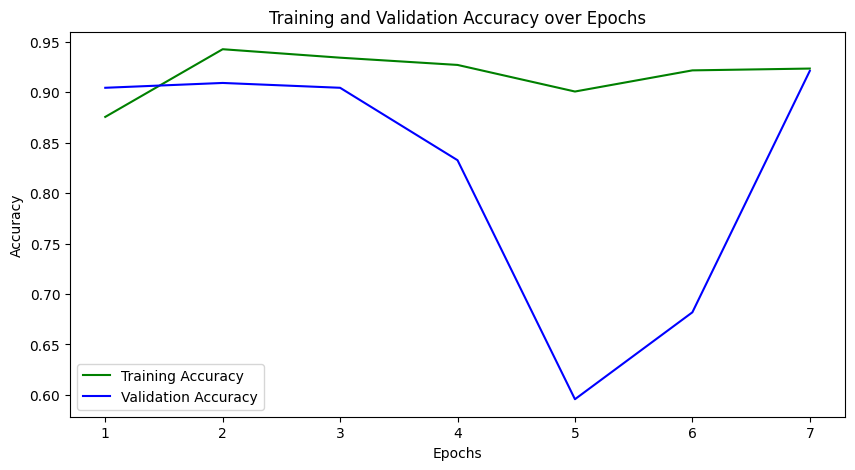

In [87]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
# Use len(history['train_acc']) to ensure we're using the correct number of epochs
epochs = range(1, len(history['train_acc']) + 1)
plt.plot(epochs, history['train_acc'], 'g', label='Training Accuracy')
plt.plot(epochs, history['val_acc'], 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()